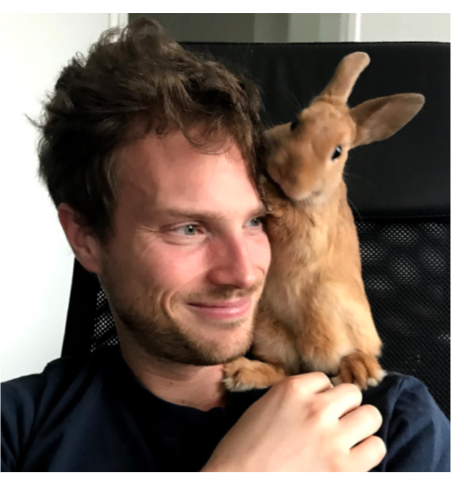

In [6]:
from IPython.display import Image
Image("img/JohnnyPic.png")

# Generative modelling with Auto-Encoders
Author: Johnny Raine (University of Geneva)

In this tutorial, you will use several different implementations of auto-encoders (AE) and employ them for use in generative modelling

The three following architectures will be used
 * Autoencoder (AE)
 * Variational Autoencoder (VAE)
 * Adversarial Autoencoder (AAE)

This tutorial will be performed in tensorflow 2.0 with extensive use of the keras API. Only basic layer types will be used.

The network is trained in order to get an encoded representation which can be sampled from in order to generate new events. 

Get the regular imports we will use when creating simple networks

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

Reproducibility!

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Generative modelling
After training an autoencoder we have an encoded representation, that hopefully will have a maximally information dense latent space. By sampling from points in this latent space and passing them through the decoder we will reconstruct new events.

A big challenge on this is to make sure we can sample from the latent space, and so the distribution in the LS is of high importance.
* It should be easy from which to sample (representive of encoded data)
* It should interpolate - we want new events, not just randomly choosing those we used from training
    * If there are empty regions in our latent space, what happens if we sample from these?
    * Do we have an easy, memory efficient way to store the latent space representation
    
For this tutorial we will look at generating new showers from photons with the ATLAS detector. This is a simplified problem where we will focus only on photons of a single energy in a single eta bin. This can be expanded to multiple energies and $\eta$ values with conditioning.
An additional simplification is that we will only look at the middle layer in the EM calorimeter.

## Data preprocessing

In [3]:
path = '/eos/user/a/aighosh/VAE_Tutorial_AML_2019/datasets/Calo/'
#path = './datasets/Calo'

Our data is packaged as numpy arrays, with an array for the deposited energy in each cell per event. Additionally we have some meta-data arrays, with the eta position of the eta and phi coordinates of the cells.
Finally we also have the truth energy of the incoming photon. The photon energy is in log2 steps from 1 to 256 GeV.

In [4]:
cell_energies = np.load(path+'MiddleOnly_CellEnergies.npy').astype(np.float32) # energy deposition
cell_eta = np.load(path+'MiddleOnly_CellEta.npy').astype(np.float32) # geometry info
cell_phi = np.load(path+'MiddleOnly_CellPhi.npy').astype(np.float32) # geometry info
true_E = np.load(path+'TrueEnergy.npy').astype(np.float32) ## for conditioning on eta, or selecting an energy bin

Looking at two random showers and the average shower

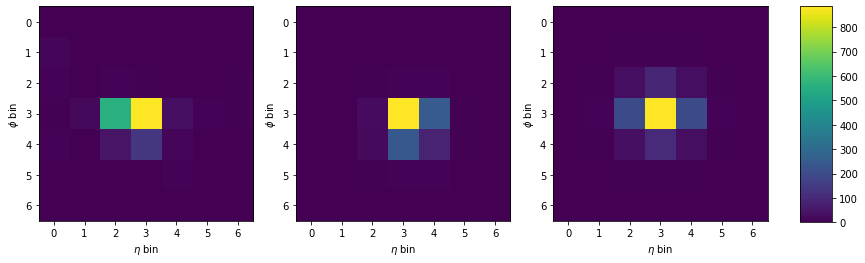

In [5]:
# plt.imshow(np.sum(cell_energies[(true_E == 65535.99609375) | (true_E ==  65536.)].reshape(-1,7,7),axis=0))
fig,axes = plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(15,5)
im = axes[0].imshow(cell_energies[0].reshape(7,7))

axes[1].imshow(cell_energies[100].reshape(7,7))
axes[2].imshow(np.sum(cell_energies.reshape(-1,7,7),axis=0)/len(cell_energies))
for ax in axes:
    ax.set_xlabel(r'$\eta$ bin')
    ax.set_ylabel(r'$\phi$ bin')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)

What about the average eta and phi distributions?

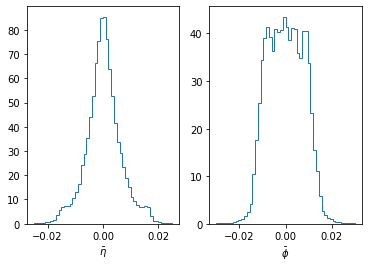

In [56]:
fig,axes = plt.subplots(nrows=1,ncols=2)
avg_eta = np.ma.average(cell_eta,weights=cell_energies,axis=1)
avg_phi = np.ma.average(cell_phi,weights=cell_energies,axis=1)
axes[0].hist(avg_eta, bins=50,range=(-0.025,0.025), histtype='step', density=True)
axes[0].set_xlabel(r'$\bar{\eta}$')
axes[1].hist(avg_phi, bins=50,range=(-0.03,0.03), histtype='step', density=True)
axes[1].set_xlabel(r'$\bar{\phi}$')
plt.show()

For training we need to work with a normalised range for our data, this is by no means optiminal and preprocessing of inputs is an important step to getting good performance

In [30]:
renorm_energies = np.max(np.mean(cell_energies))

In [31]:
cell_energies = cell_energies / renorm_energies
true_E = np.log2(true_E)

In [32]:
split = int(0.8*len(cell_energies))

In [33]:
x_train = cell_energies[:split]#Something with jets or calo
x_val   = cell_energies[split:]

c_train = true_E[:split]
c_val   = true_E[split:]

## Autoencoder
An autoencoder consists of three main components
* Encoder (Network)
* Latent Space (Representation)
* Decoder (Network)

Specify the number of dimensions we want to have in our latent space and number of input features will have

In [34]:
num_features = x_train.shape[1]
num_dim = 5

Now some training specifics, number of epochs to train and batch size, as well as optimiser

In [35]:
num_epochs = 10
batch_size = 128
optimizer = Adam(lr=1e-4)

Specify the basic architecture of our network.

Autoencoders work on the idea of an information bottle neck, with layers typically reduce in size as they get closer to the latent space.

After the latent space the reverse of the architecture is normally used - however this is not a necessity. Autoencoders can be asymmetric.

In [36]:
layers = [32,16]#[128,64,32]
activation = 'relu'
# batch_norm = False

Define functions to get the encoder and decoders

In [37]:
def get_encoder(n_features,latent_dim,layers):
    '''Create a keras model for the vanila encoder network
    Arguments
        n_features: (int) number of input features
        latent_dim: (int) number of dimensions of latent space
        layers: (list of int) number of units in hidden layers
    Returns
        keras functional Model for encoder
    '''
    assert len(layers)>0, "Need at least one layer to be defined"
    inputs = Input(shape=(n_features,))
    hidden = Dense(units=layers[0],activation=activation)(inputs)
    i = 1
    while(i < len(layers)):
        hidden = Dense(units=layers[i],activation=activation)(hidden)
        i += 1
    latent = Dense(units=latent_dim,activation='linear')(hidden)
    encoder = Model(inputs=inputs,outputs=latent)
    return encoder

In [38]:
def get_decoder(n_features,latent_dim,layers):
    '''Create a keras model for the vanila decoder network
    Arguments
        n_features: (int) number of input features
        latent_dim: (int) number of dimensions of latent space
        layers: (list of int) number of units in hidden layers
    Returns
        keras functional Model for decoder
    '''
    assert len(layers)>0, "Need at least one layer to be defined"
    latent = Input(shape=(latent_dim,))
    hidden = Dense(units=layers[0],activation=activation)(latent)
    i = 1
    while(i < len(layers)):
        hidden = Dense(units=layers[i],activation=activation)(hidden)
        i += 1
    outputs = Dense(units=n_features,activation='linear')(hidden)
    decoder = Model(inputs=latent,outputs=outputs)
    return decoder

Get instance of encoder and decoder and construct a model for training

The output of the encoder is the latent space, which is subsequently the input to decoder

In [39]:
ae_encoder = get_encoder(num_features,num_dim,layers)
ae_decoder = get_decoder(num_features,num_dim,layers[::-1])

In [40]:
encoder_in = Input(shape=(num_features,))
ae_latent_space = ae_encoder(encoder_in)
decoder_out = ae_decoder(ae_latent_space)
ae_model = Model(inputs=encoder_in,outputs=decoder_out)

Train with either mean square error or binary cross entropy loss

In [41]:
ae_model.compile(optimizer=optimizer,loss='mse') # 'mse' or 'binary_crossentropy'

In [42]:
ae_model.fit(x_train,x_train,shuffle=True,batch_size=batch_size,epochs=num_epochs,validation_data=[x_val,x_val])

Train on 70400 samples, validate on 17600 samples
Epoch 1/10
70400/70400 [==============================] - 3s 42us/sample - loss: 40.7713 - val_loss: 9.3575
Epoch 2/10
70400/70400 [==============================] - 2s 27us/sample - loss: 7.8218 - val_loss: 6.5991
Epoch 3/10
70400/70400 [==============================] - 2s 28us/sample - loss: 4.8239 - val_loss: 3.8193
Epoch 4/10
70400/70400 [==============================] - 2s 27us/sample - loss: 3.2734 - val_loss: 2.8177
Epoch 5/10
70400/70400 [==============================] - 2s 28us/sample - loss: 2.1598 - val_loss: 1.7546
Epoch 6/10
70400/70400 [==============================] - 2s 27us/sample - loss: 1.2503 - val_loss: 0.9605
Epoch 7/10
70400/70400 [==============================] - 2s 27us/sample - loss: 0.6716 - val_loss: 0.5400
Epoch 8/10
70400/70400 [==============================] - 2s 27us/sample - loss: 0.3841 - val_loss: 0.3681
Epoch 9/10
70400/70400 [==============================] - 2s 27us/sample - loss: 0.2876 - val

### Performance

Lets look at how the autoencoder is performing at reconstructing individual showers. For this we can compare use the validation dataset.

In [43]:
from caloae import showerPlot, LSPlot

First the input showers

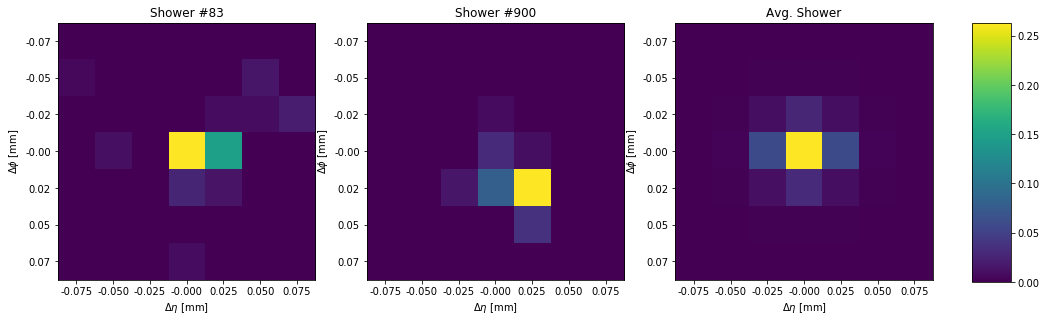

In [44]:
showerPlot(cell_energies, cell_eta, cell_phi)

Now the ones we have passed through the autoencoder

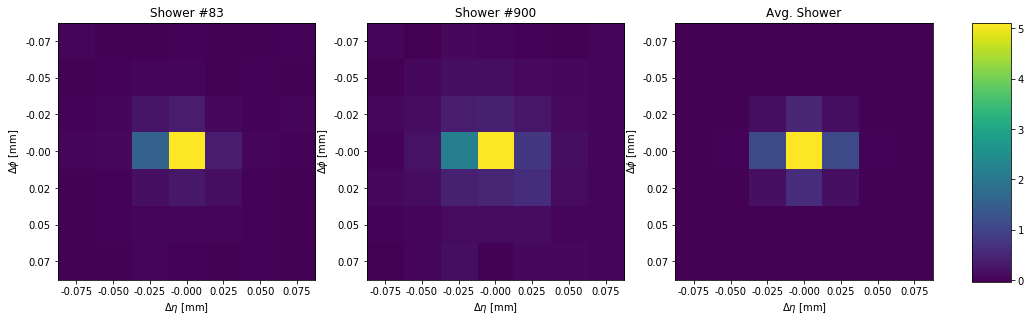

In [45]:
ae_showers = ae_model(x_val)
showerPlot(ae_showers, cell_eta, cell_phi)

We are also interested in what the latent space looks like, when it comes to generation we will want to start from here!

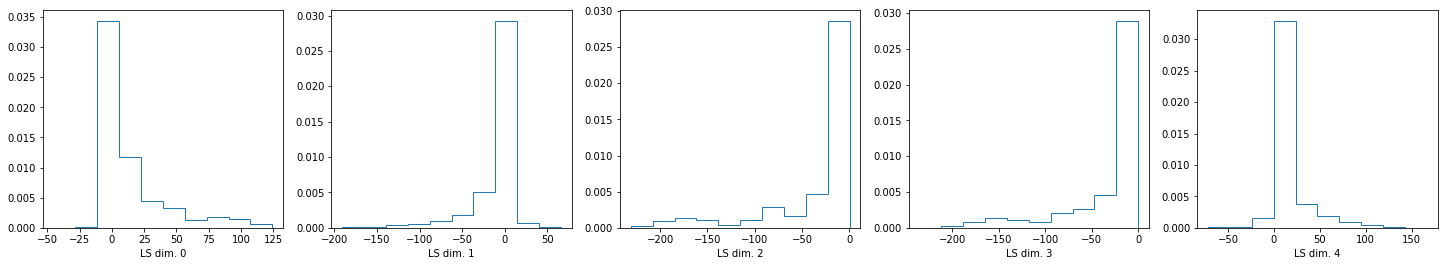

In [22]:
LSPlot(ae_encoder(x_val))

## Conditioning
Normally for generation we will want to have what we generate dependent on a quantitiy. For example in calorimeter simulation, we will went our showers we generate to be dependent on the energy, the species, and the direction of travel of the incoming particle.

In order to implement this, a small change is requied to the architecture. For an AE, the "conditional" quantity is used as an additional input to the encoder, just like any other feature. However, in addition to this, it is also given as an input to the decoder, alongside the latent representation. This way, we are able to decode the representation also dependent on some condition.

Then when we come to the generation, we will sample from our latent space as normal, and then also provide the value we want to generate for - for example a shower for a photon with 65 GeV.

In [23]:
from tensorflow.keras.layers import Concatenate

In [24]:
num_condition = 1

In [25]:
c_ae_encoder = get_encoder(num_features+num_condition,num_dim,layers)
c_ae_decoder = get_decoder(num_features,num_dim+num_condition,layers)

In [26]:
condition = Input(shape=(1,))
combined_enc_in = Concatenate()([encoder_in,condition])
latent_space = c_ae_encoder(combined_enc_in)
combined_dec_in = Concatenate()([latent_space,condition])
decoder_out = c_ae_decoder(combined_dec_in)
conditional_ae_model = Model(inputs=[encoder_in,condition],outputs=decoder_out)

In [27]:
conditional_ae_model.compile(optimizer=optimizer,loss='mse') # 'mse' or 'binary_crossentropy'

In [28]:
conditional_ae_model.fit([x_train,c_train],x_train,shuffle=True,batch_size=batch_size,epochs=num_epochs,validation_data=[[x_val,c_val],x_val])

Train on 70400 samples, validate on 17600 samples
Epoch 1/10
70400/70400 [==============================] - 3s 38us/sample - loss: 19.3816 - val_loss: 7.4619
Epoch 2/10
70400/70400 [==============================] - 2s 28us/sample - loss: 6.1552 - val_loss: 4.7902
Epoch 3/10
70400/70400 [==============================] - 2s 29us/sample - loss: 4.0128 - val_loss: 3.7499
Epoch 4/10
70400/70400 [==============================] - 2s 29us/sample - loss: 3.2565 - val_loss: 2.9459
Epoch 5/10
70400/70400 [==============================] - 2s 29us/sample - loss: 2.3530 - val_loss: 2.0077
Epoch 6/10
70400/70400 [==============================] - 2s 28us/sample - loss: 1.5343 - val_loss: 1.2345
Epoch 7/10
70400/70400 [==============================] - 2s 28us/sample - loss: 0.9671 - val_loss: 0.8614
Epoch 8/10
70400/70400 [==============================] - 2s 28us/sample - loss: 0.6752 - val_loss: 0.5893
Epoch 9/10
70400/70400 [==============================] - 2s 29us/sample - loss: 0.4195 - val

## Variational Autoencoder
 * Changes wrt autoencoder: No longer encoding an exact representation but a distribution
 * Requires us to change:
     * Encoder
     * Loss function
     
Need to mention reparametrisation trick and ELBO, introduce $\beta$ term in $\beta$-VAE

For the VAE we will need to define two custom layers
 * Combine the predicted mu and sigma of the gaussian distribution into a sampled value
 * Calculate the KL divergence of the latent space distribution from the unit gaussian and add as a loss
For the sampling, we will define a function and apply it using a Lambda layer

For the KL divergence loss, we will define a custom keras layer, and inside the call instance calculate the KL divergence of the true LS from the prior (Gaussian normal) and add it as a loss term.

To get the best balance between the latent space being Gaussian and the reconstruction loss, we often work with $\beta$-VAE, where there is an additional hyperparameter to tune, $\beta$ which changes the relationship between the two loss terms.

In [29]:
from tensorflow.keras.layers import Layer,Lambda
import tensorflow.keras.backend as K

In [30]:
class KLDivergenceLayer(Layer):
    '''Custom layer to implement the addition of the KL divergence term to the loss in the cost function for a VAE'''

    def __init__(self, weight=1.0, **kwargs):
        self.is_placeholder = True
        self.weight = weight
        super(KLDivergenceLayer,self).__init__(**kwargs)

    def call(self, z):
        z_mu, z_logsig = z
        kl_loss = 1 + z_logsig - K.square(z_mu) - K.exp(z_logsig)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        self.add_loss(self.weight * K.mean(kl_loss), inputs=z)
        return z
    
    def get_config(self):
        config={'weight': self.weight}
        base_config = super(KLDivergenceLayer,self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

For the encoder in the VAE it has the same principle as the standard encoder, however instead of predicting a point in N dimensions per event, you predict a mean and standard deviation. This means for each event it has a central point, and then some variational displacement around it.

In [31]:
def get_variational_encoder(n_features, latent_dim, layers, weight=1.0):
    '''Create a keras model for the variational encoder network
    Arguments
        n_features: (int) number of input features
        latent_dim: (int) number of dimensions of latent space
        layers: (list of int) number of units in hidden layers
        weight: weight for the KL loss term. Trade off importance of Gaussianality of LS with reconstruction performance
    Returns
        keras functional Model for encoder
    '''
    assert len(layers), "Need at least one layer to be defined"
    inputs = Input(shape=(n_features,))
    hidden = Dense(units=layers[0],activation=activation)(inputs)
    i = 1
    while(i < len(layers)):
        hidden = Dense(units=layers[i],activation=activation)(hidden)
        i += 1

    z_mu = Dense(latent_dim,activation='linear',name='z_mu')(hidden)
    z_logsig = Dense(latent_dim,activation='linear',name='z_logsig',kernel_initializer='zeros')(hidden)
    z_mu, z_logsig = KLDivergenceLayer(weight=weight)([z_mu, z_logsig])

    encoder = Model(inputs=inputs,outputs=[z_mu]+[z_logsig])
    return encoder

Here we sample one value Z from mu and sigma

In [32]:
def sampleZ(z):
    '''Sampling function of Gaussian latent space.
    Combines mu and sigma tensors with Z = mu + eps*sig, where eps is random normal centred on zero'''
    mu, logsig = z
    epsilon = K.random_normal( K.shape(mu) ,dtype='float32')
    return mu+epsilon*K.exp(logsig)

The reconstruction loss is modified slightly just to be of the same order as the KL divergence loss

In [33]:
from tensorflow.keras.losses import mse,binary_crossentropy
def vae_reconstruction_loss(use_mse=False):
    '''Modified loss for use in VAE. Multiplies either MSE or binomial crossentropy by number of features'''
    def loss(y_true, y_pred):
        if use_mse:
            return K.int_shape(y_pred)[1] * mse(y_true, y_pred)
        else:
            return K.int_shape(y_pred)[1] * binary_crossentropy(y_true, y_pred)
    return loss

Once again get an encoder and decoder, and construct the VAE model

The output of the encoder is two tensors: mu and sigma

The input of the decoder is a single value tensor Z = $\mu$ + $\epsilon*\sigma$

In [34]:
vae_encoder = get_variational_encoder(num_features,num_dim,layers)
vae_decoder = get_decoder(num_features,num_dim,layers[::-1])

In [35]:
encoder_in = Input(shape=(num_features,))
vae_latent_dist = vae_encoder(encoder_in)

In [36]:
vae_latent_sampled = Lambda(sampleZ)(vae_latent_dist)
decoder_out = vae_decoder(vae_latent_sampled)
vae_model = Model(inputs=encoder_in,outputs=decoder_out)

Compile and train the VAE model

In [37]:
vae_model.compile(optimizer=optimizer,loss='mse') # 'mse' or 'binary_crossentropy'

In [38]:
vae_model.fit(x_train,x_train,shuffle=True,batch_size=batch_size,epochs=num_epochs,validation_data=[x_val,x_val])

Train on 70400 samples, validate on 17600 samples
Epoch 1/10
70400/70400 [==============================] - 3s 41us/sample - loss: 43.8833 - val_loss: 27.7749
Epoch 2/10
70400/70400 [==============================] - 2s 30us/sample - loss: 23.8526 - val_loss: 21.0466
Epoch 3/10
70400/70400 [==============================] - 2s 30us/sample - loss: 18.9584 - val_loss: 17.2135
Epoch 4/10
70400/70400 [==============================] - 2s 31us/sample - loss: 15.7028 - val_loss: 14.4194
Epoch 5/10
70400/70400 [==============================] - 2s 31us/sample - loss: 13.3479 - val_loss: 12.5358
Epoch 6/10
70400/70400 [==============================] - 2s 30us/sample - loss: 11.9443 - val_loss: 11.4545
Epoch 7/10
70400/70400 [==============================] - 2s 31us/sample - loss: 11.1209 - val_loss: 10.8191
Epoch 8/10
70400/70400 [==============================] - 2s 31us/sample - loss: 10.6249 - val_loss: 10.3825
Epoch 9/10
70400/70400 [==============================] - 2s 30us/sample - los

Of course we probably want to stick to conditioning

In [39]:
c_vae_encoder = get_variational_encoder(num_features+num_condition,num_dim,layers)
c_vae_decoder = get_decoder(num_features,num_dim+num_condition,layers[::-1])

In [40]:
vae_condition = Input(shape=(1,))
combined_vae_enc_in = Concatenate()([encoder_in,vae_condition])
c_vae_latent_dist = c_vae_encoder(combined_vae_enc_in)

In [41]:
c_vae_latent_sampled = Lambda(sampleZ)(c_vae_latent_dist)
combined_dec_in = Concatenate()([c_vae_latent_sampled,vae_condition])
c_decoder_out = c_vae_decoder(combined_dec_in)
conditional_vae_model = Model(inputs=[encoder_in,vae_condition],outputs=c_decoder_out)

conditional_vae_model.compile(optimizer=optimizer,loss='mse') # 'mse' or 'binary_crossentropy'

In [42]:
conditional_vae_model.fit([x_train,c_train],x_train,shuffle=True,batch_size=batch_size,epochs=num_epochs,validation_data=[[x_val,c_val],x_val])

Train on 70400 samples, validate on 17600 samples
Epoch 1/10
70400/70400 [==============================] - 3s 42us/sample - loss: 44.0484 - val_loss: 30.9880
Epoch 2/10
70400/70400 [==============================] - 2s 32us/sample - loss: 27.8254 - val_loss: 24.9297
Epoch 3/10
70400/70400 [==============================] - 2s 32us/sample - loss: 22.1558 - val_loss: 19.2738
Epoch 4/10
70400/70400 [==============================] - 2s 32us/sample - loss: 17.0629 - val_loss: 15.3237
Epoch 5/10
70400/70400 [==============================] - 2s 32us/sample - loss: 14.1793 - val_loss: 13.2698
Epoch 6/10
70400/70400 [==============================] - 2s 32us/sample - loss: 12.5954 - val_loss: 11.9827
Epoch 7/10
70400/70400 [==============================] - 2s 32us/sample - loss: 11.5841 - val_loss: 11.2868
Epoch 8/10
70400/70400 [==============================] - 2s 32us/sample - loss: 11.0886 - val_loss: 10.9246
Epoch 9/10
70400/70400 [==============================] - 2s 32us/sample - los

### Performance

First the input showers

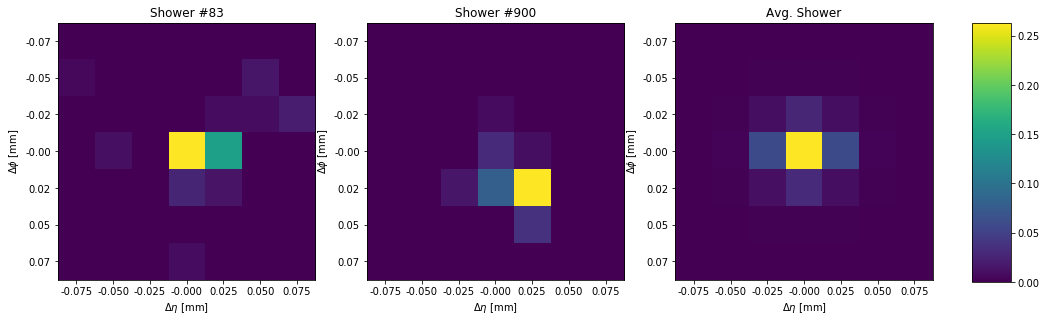

In [43]:
showerPlot(cell_energies, cell_eta, cell_phi)

Now the ones we have passed through the autoencoder

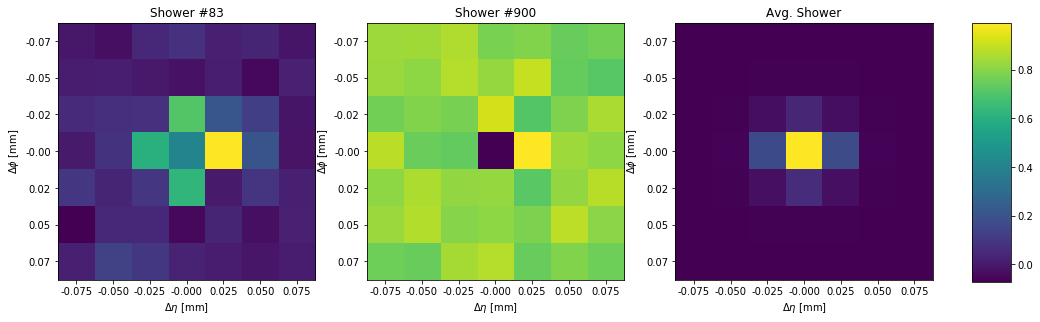

In [44]:
cvae_showers = conditional_vae_model.predict([x_val,c_val])
showerPlot(cvae_showers, cell_eta, cell_phi)

We get a mu and sigma tensor out of our encoder, so again we will sample with epsilon to produce Z

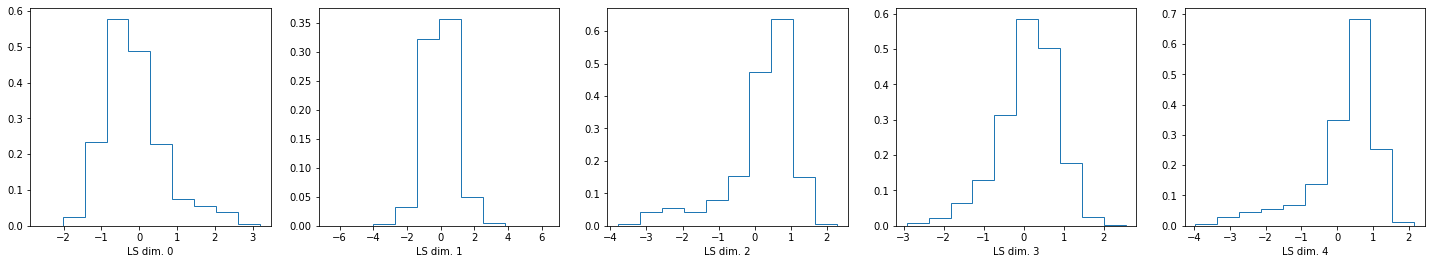

In [45]:
cvae_ls_mu,cvae_ls_sig = c_vae_encoder(np.concatenate([x_val,c_val.reshape(-1,1)],axis=1))
cvae_Z = sampleZ((cvae_ls_mu,cvae_ls_sig))
LSPlot(cvae_Z)

The latent space looks a little bit more regular, thanks to the reparametrisation trick and the KL loss term to enforce a prior on the latent space.
However, the reconstruction performance and agreement with the prior is a trade off

## Adversarial Autoencoder
 * Another way to approach the same problem:
     * Instead of encoding a distribution go back to encoding representation
     * Use a discriminator to enforce distribution of choice
     * Adversarial approach, allows full freedom of choice of distribution in latent space
 * Changes wrt autoencoder:
     * Additional network - Discriminator
     * Adversarial training - can no longer use standard training procedure

The adversarial autoencoder is a little bit more involved.
We can no longer simply define an encoder, decoder, combine them and train. Because we are looking at an adversarial approach, we now need to train two networks which want to go in opposite directions.

This means we will need to train, per batch, the discriminator and then the autoencoder.
We want the discriminator to be able to best separate our prior from what is produced with our network. We give the encoded events one label, and the prior events another, the discriminator then learns to maximallt separate them.
After training our discriminator, we freeze its weights so that they remain fixed during the training of the autoencoder.

When we train our autoencoder, we pass our events through the trained discriminator at the same time, and end up with a combined loss term. This means that the error from the discriminator also flows back through the network, and so minimising this loss term impacts the weights in the encoder.
The trick here is that we now set the labels of encoded events to be the same as we used for the prior distribution in the discriminator training. This way, to minimise the discriminator loss, our events have to become more "prior" like in the latent space. 

When training the network, with the discriminator weights frozen, the error from discriminator flows back through the encoder, and minimising the discriminator loss also becomes a goal of the network during training. As the loss was trained to separate this batch from the true prior distribution, the way to reduce the loss further on the batch is to become more like the prior distribution in the latent space.
As our events become harder to distinguish from the prior distribution by the discriminator the discriminator loss will reduce, and so our latent space takes on the form of our prior.

In the ideal case, our discrinator accuracy will be 50%, and our reconstruction loss will be zero. More than likely it will be a fine balance nad a trade off. Therefore, we need to specify weights for each of the loss terms as well, this is akin to the $\beta$ term in the VAE for the KL loss term.

In order to do all this we need to:
* Create a discriminator model
* Have our own function to get the batches of training data
* Sample true events from our prior
* Create our own loop to train the discriminator and autoencoder on batches

In [46]:
def get_discriminator(n_inputs,layers):
    '''Create a keras model for a binary discriminator network
    arguments
        n_inputs: (int) number of input features
        layers: (list of int) number of units in hidden layers
    returns
        keras functional Model for binary discriminator
    '''
    assert len(layers), "Need at least one layer to be defined"
    inputs = Input(shape=(n_inputs,))
    hidden = Dense(units=layers[0],activation=activation)(inputs)
    i = 1
    while(i < len(layers)):
        hidden = Dense(units=layers[i],activation=activation)(hidden)
        i += 1
    output = Dense(units=1,activation='sigmoid')(hidden)
    discriminator = Model(inputs=inputs,outputs=output)
    return discriminator

Here is a generator to return indices for a single batch.

Per epoch, each index will be returned only once. If the batch size is not a factor of the number of training events, then there will be a remained of events per epoch which are not used for training. As the batch sampling is random this should not be the same per epoch, though due to the nature of random selection it could be, who knows, I'll let you calculate the probability!

In [47]:
def get_batch(ntrain,batch_size,nepochs):
    '''Generator for retrieving batches of indices
    Arguments
        ntrain: (int) Number of training events
        batch_size: (int) number of events in single batch
        nepochs: (int) total number of epochs to train
    Returns
        Array of indices of size batch_size, sampled from range ntrain.
        Indices returned will be unique before next epoch starts
        All indices will be returned once per epoch, minus a remainder where ntrain % batch_size != 0'''
    j = 0
    while j < nepochs:
        nbatch = int(ntrain / batch_size)
        sequence = np.random.randint(0,ntrain,ntrain)
        i = 0
        while i < nbatch:
            yield sequence[i*batch_size:(i+1)*batch_size]
            i += 1
        j += 1

To train the discriminator we must enable it as trainable (nominally false so that it does not adapt as we train our autoencoder).

We calculate the loss on real events, and the loss on fake events, then combine these to get the average loss per event.

In [48]:
def train_discriminator(network,real,fake):
    '''Get function to trian a discriminator network using real and fake samples
    Arguments
        network: Discriminator network
        real: training labels for batch of real events
        fakse: training labels for batchof fake events
    Returns
        Function train(real_samples,fake_samples)
        Discriminator training function for batch of real and fake samples'''
    def train(real_samples,fake_samples):
        network.trainable = True

        loss_real = network.train_on_batch(real_samples,real)
        loss_fake = network.train_on_batch(fake_samples,fake)
        
        loss = 0.5*np.add(loss_real, loss_fake)
        
        network.trainable = False
        
        return loss
    return train

In [49]:
def sample_prior(latent_dim,batch_size,uniform=False):
    '''Sample from the prior distribution of latent space (flat uniform or gaussian in Ndim)
    Arguments
        latent_dim: (int) number of latent space dimensions
        batch_size: (int) nunber of events per batch
        uniform: (bool) Use a flat uniform prior
        '''
    shape = (batch_size,latent_dim)
    if uniform:
        return np.random.uniform(size=shape)
    else:
        return np.random.normal(size=shape)

Time to get a vanilla encoder and decoder, the adversarial autoencoder is almost identical to the vanilla autoencoder, but during training we have the addition of the discriminator and this adds all the complexity and increases the training time.

In [50]:
aae_encoder = get_encoder(num_features,num_dim,layers)
aae_decoder = get_decoder(num_features,num_dim,layers[::-1])

In [51]:
discr_prior = get_discriminator(n_inputs=num_dim,
                                layers=[10,10])

discr_prior.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])

discr_prior.trainable = False

In [52]:
encoder_in = Input(shape=(num_features,))
aae_latent_space = aae_encoder(encoder_in)
decoder_out = aae_decoder(aae_latent_space)

discr_out = discr_prior(aae_latent_space)
aae_encode_decode = Model(inputs=encoder_in,outputs=[aae_latent_space,decoder_out])

aae_model = Model(inputs=encoder_in,outputs=[decoder_out,discr_out])

In [53]:
real = np.ones((batch_size,1))
fake = np.zeros((batch_size,1))
train_prior_discr = train_discriminator(discr_prior,real,fake)

In [54]:
#Log keeping
batch_prior_loss = []
batch_reco_loss  = []
loss       = []
val_loss   = []

In this model we now need to define two losses, one for the autoencoder and the other for the discriminator. In addition, we can specify a loss weight, this is how we control the trade-off between the two goals.

In [55]:
aae_model.compile(loss=['mse','binary_crossentropy'],
                  loss_weights=[0.975,0.025],
                  optimizer=optimizer)

For the training we need to define a loop over the batches. Within this loop we first update the discriminator which aims to separate the encoded representation of the batch from the prior distribution of the latent space.
Then we freeze the discriminator weights again, and move back to training the autoencoder. When training the autoencoder, the loss which is minimised is the autoencoder reconstruction loss + discriminator loss. To minimise this, the LS becomes more like the prior distribution as well as the reconstruction becoming closer to the input.

In [56]:
ntrain = len(x_train)
epoch_number = 0
batch_number = 0
nbatch = int(ntrain / batch_size)
print("Training {} epochs with {} batches per epoch".format(num_epochs,nbatch))
for batch_idx in get_batch(ntrain,batch_size,num_epochs):        
    batch = x_train[batch_idx]
    latent_fake,_ = aae_encode_decode.predict(batch)
    latent_true = sample_prior(num_dim,batch_size)
    
    batch_prior_loss.append(train_prior_discr(latent_true,latent_fake))
    batch_reco_loss.append(aae_model.train_on_batch(batch, [batch,real]))
    
    batch_number += 1
    if batch_number == nbatch:
        epoch_number += 1
        batch_number = 0
        val_loss.append(aae_model.evaluate(x_val, [x_val,np.ones(len(x_val))],verbose=0))
        loss.append(batch_reco_loss[-1])
        print("Epoch {}/{}: Loss = {}. Val loss = {}".format(epoch_number,num_epochs,loss[-1][1],val_loss[-1][1]))

Training 10 epochs with 550 batches per epoch
Epoch 1/10: Loss = 6.083329200744629. Val loss = 4.29011344909668
Epoch 2/10: Loss = 3.5774755477905273. Val loss = 2.282247304916382
Epoch 3/10: Loss = 0.7729135155677795. Val loss = 0.9161376357078552
Epoch 4/10: Loss = 0.398311048746109. Val loss = 0.45079296827316284
Epoch 5/10: Loss = 0.2752090394496918. Val loss = 0.31646838784217834
Epoch 6/10: Loss = 0.0966416448354721. Val loss = 0.2590048611164093
Epoch 7/10: Loss = 0.19816403090953827. Val loss = 0.22393277287483215
Epoch 8/10: Loss = 0.06456705927848816. Val loss = 0.19386860728263855
Epoch 9/10: Loss = 0.07886451482772827. Val loss = 0.1717033088207245
Epoch 10/10: Loss = 0.06670822203159332. Val loss = 0.15410935878753662


### Performance

First the input showers

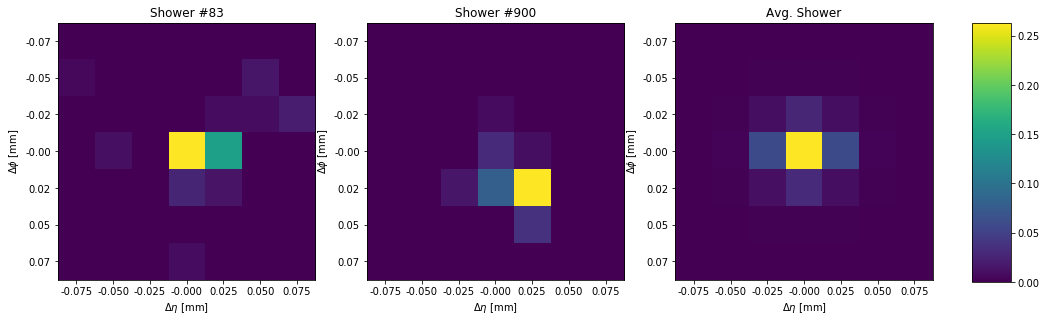

In [57]:
showerPlot(cell_energies, cell_eta, cell_phi)

Now the ones we have passed through the autoencoder

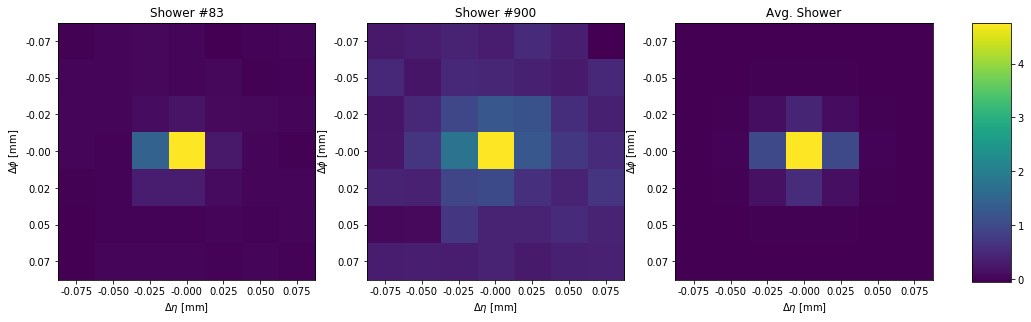

In [58]:
aae_showers,aae_discr = aae_model(x_val)
showerPlot(aae_showers, cell_eta, cell_phi)

We are also interested in what the latent space looks like, when it comes to generation we will want to start from here!

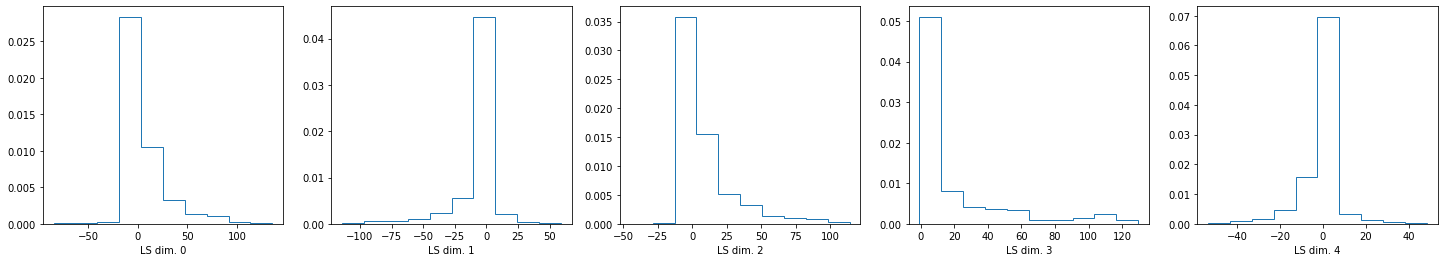

In [59]:
LSPlot(aae_encoder(x_val))

This can also be done with conditioning, following the same principle as above. However, as adversarial trainings take longer to train and converge, let's leave it for now.

# Now for generation
We have trained multiple autoencoders to encode a representative latent space, and then decode this back to what we started with.
For generation we now care about creating new example which weren't in the dataset.

The standard way to do this is to start from the latent space and using noise as an input into the decoder. This then acts as a generator and converts our noise in the latent space to new example events. However, we cannot use any random noise for this, we should sample from the distribution of events in the latent space.

As you can see, this presents a problem for the vanilla autoencoder, which doesn't have any explicit shape or form. We could use some cluster or try and fit a model to the latent space, but this is a lot of work and the interpolation regions could be very far away from real-like events.

The VAE is a vast improvement here, as we now have a gaussian latent space in each latent space dimension. Additionally, due to the reparametrisation trick, the same event when encoded has a mean position with some uncertainty from the $\sigma$ values, which improves the stabiliy and interpolation.
To sample from the VAE, if we have a truly uncorrelated gaussian latent space, we can sample N random numbers from a unit gaussian and use these as an input to the generator.
However, if our Latent space is not perfectly gaussian or has correlations we will need to model these or our sampling will not be representative.

The AAE similarly is easier to sample from, however the benefit here is that we can specify our prior distribution in the latent space to be anything we want. This gives us much more freedome for sampling from the latent space.

In [60]:
noise_Z = np.random.normal(size=(1000,num_dim)).astype(np.float32)
showers = vae_decoder(noise_Z)

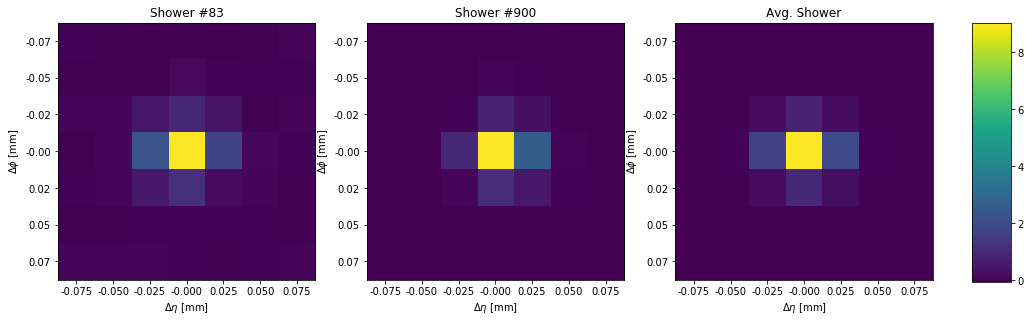

In [61]:
showerPlot(showers, cell_eta, cell_phi)

We can do the same with conditioning too!

First looking at low energy showers with $E=2^{10}$ MeV$=1$ GeV

In [62]:
noise_Z = np.random.normal(size=(1000,num_dim)).astype(np.float32)
condition = np.repeat([10],1000).reshape(-1,1)
c_showers = c_vae_decoder(np.concatenate([noise_Z,condition],axis=1).astype(np.float32))

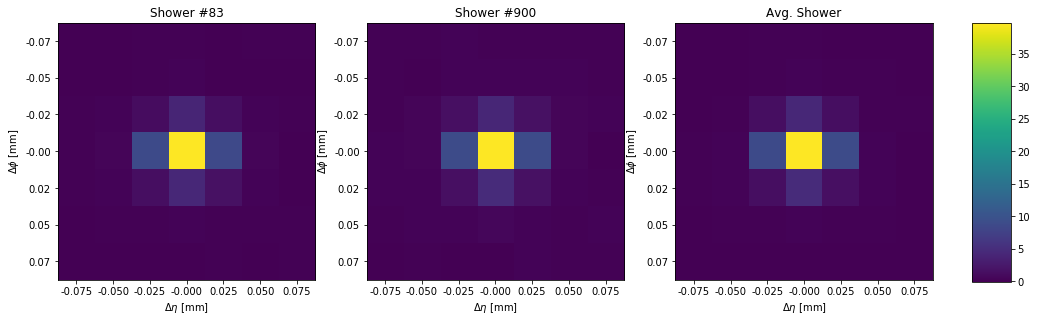

In [63]:
showerPlot(c_showers, cell_eta, cell_phi)

And now some new showers with $E=2^{16}$ MeV $=65$ GeV

In [64]:
noise_Z = np.random.normal(size=(1000,num_dim)).astype(np.float32)
condition = np.repeat([16],1000).reshape(-1,1)
c_showers = c_vae_decoder(np.concatenate([noise_Z,condition],axis=1).astype(np.float32))

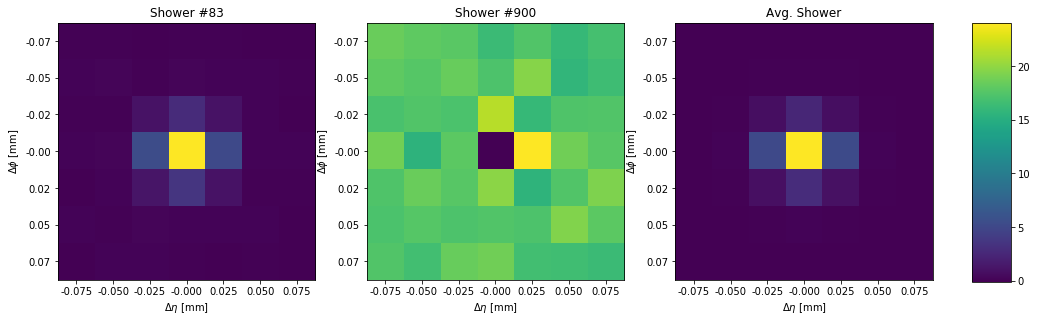

In [65]:
showerPlot(c_showers, cell_eta, cell_phi)

We can also check that the total energy in the layer is being well modelled at each of the conditioned energy points, in comparison to G4.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


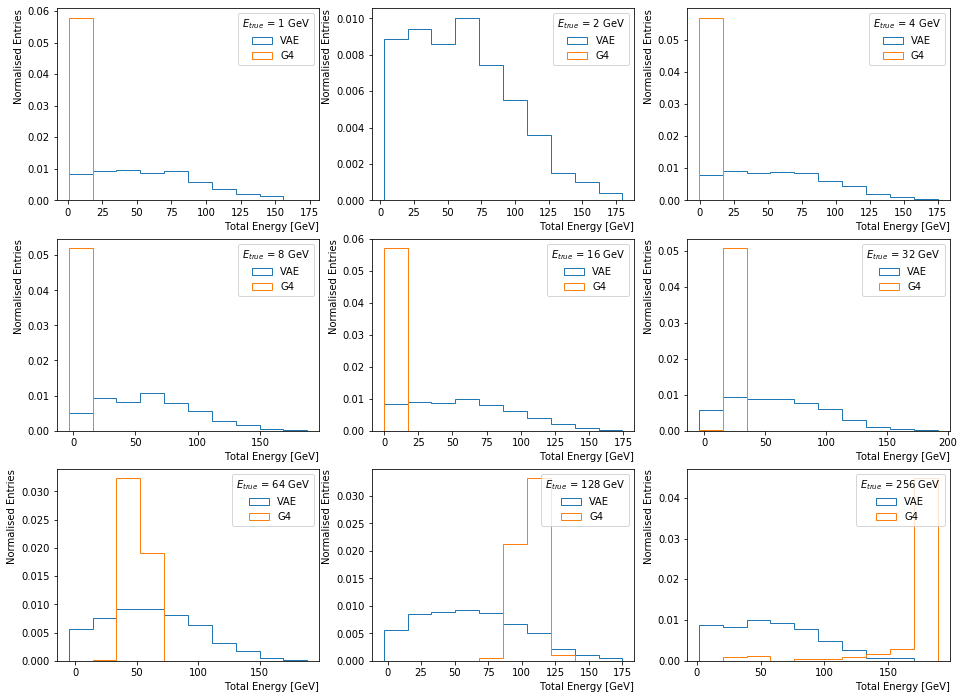

In [66]:
fig,axes = plt.subplots(3,3)
fig.set_size_inches(16,12)
for x in range(9):
    xplt = int(x / 3)
    yplt = x % 3
    noise_Z = np.random.normal(size=(1000,num_dim)).astype(np.float32)
    condition = np.repeat([16],1000).reshape(-1,1)
    c_showers = c_vae_decoder(np.concatenate([noise_Z,condition],axis=1).astype(np.float32)) / 1024.0
    _,bins,_ = axes[xplt][yplt].hist(np.sum(renorm_energies*c_showers,axis=1),density=True,label='VAE',histtype='step')
    axes[xplt][yplt].hist(np.sum((renorm_energies / 1024.0)*cell_energies[true_E == x+10],axis=1),density=True,label='G4',bins=bins,histtype='step')
    axes[xplt][yplt].legend(title=r'$E_{{true}}$ = {} GeV'.format(2**x))
    axes[xplt][yplt].set_xlabel("Total Energy [GeV]",horizontalalignment='right',x=1.0)
    axes[xplt][yplt].set_ylabel("Normalised Entries",horizontalalignment='right',y=1.0,x=1.0)

Out of the box the agreement may not be so great, so we need to optimise the hyperparameters a lot, and balance the trade off between reproducing the shower reconstruction, and having a latent space which is easy to sample from.